In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from skimage.color import gray2rgb
from skimage.transform import resize
from PIL import Image
import warnings

# Model Training

In [ ]:
# Let's load the train, validation and test arrays
X_train = np.load('/content/drive/MyDrive/Numpy_ADNI/AmyPET_train_images.npy', allow_pickle=True)
X_val = np.load('/content/drive/MyDrive/Numpy_ADNI/AmyPET_val_images.npy', allow_pickle=True)
X_test = np.load('/content/drive/MyDrive/Numpy_ADNI/AmyPET_test_images.npy', allow_pickle=True)
Y_train = np.load('/content/drive/MyDrive/Numpy_ADNI/AmyPET_train_label.npy', allow_pickle=True)
Y_val = np.load('/content/drive/MyDrive/Numpy_ADNI/AmyPET_val_label.npy', allow_pickle=True)
Y_test = np.load('/content/drive/MyDrive/Numpy_ADNI/AmyPET_test_label.npy', allow_pickle=True)

In [ ]:
# Converting grayscale images to RGB
X_train = np.array([gray2rgb(X_train[i]) for i in range(len(X_train))])
X_val = np.array([gray2rgb(X_val[i]) for i in range(len(X_val))])
X_test = np.array([gray2rgb(X_test[i]) for i in range(len(X_test))])

In [ ]:
X_train, Y_train = shuffle(X_train, Y_train, random_state = 0)
X_val, Y_val = shuffle(X_val, Y_val, random_state = 0)
X_test, Y_test = shuffle(X_test, Y_test, random_state = 0)

In [ ]:
# Let's confirm the size of the training and validation arrays
print(f'There are {len(X_train)} images in training set')
print(f'There are {len(X_val)} images in validation set')
print(f'There are {len(X_test)} images in test set')

There are 1200 images in training set
There are 215 images in validation set
There are 250 images in test set


In [ ]:
class PETClassifier(nn.Module):
    def __init__(self, num_classes=3):
        super(PETClassifier, self).__init__()
        self.base_model = models.inception_v3(pretrained=True)

        # Unfreeze the last 2 inception blocks
        for name, param in self.base_model.named_parameters():
            if "Mixed_7" in name or "Mixed_6" in name:
                param.requires_grad = True
            else:
                param.requires_grad = False

        # Modify the final classifier with batch normalization
        num_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Sequential(
            nn.BatchNorm1d(num_features),
            nn.Dropout(0.4),  # Increased dropout
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        if self.training:
            output, aux_output = self.base_model(x)
            return output, aux_output
        return self.base_model(x)

In [ ]:
class AmyloidPETDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Normalize the image to [0, 1] range
        image = (image - image.min()) / (image.max() - image.min())

        # Convert to PIL Image
        image = Image.fromarray((image * 255).astype(np.uint8))
        image = image.convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
# Modified transforms with custom normalization
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),  # Add small translations
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.485, 0.485],
                        std=[0.229, 0.229, 0.229])
])

val_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.485, 0.485],
                        std=[0.229, 0.229, 0.229])
])

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10, device='cuda'):
    model = model.to(device)
    best_val_acc = 0.0
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs, aux_outputs = model(inputs)
            loss1 = criterion(outputs, labels)
            loss2 = criterion(aux_outputs, labels)
            loss = loss1 + 0.4 * loss2

            loss.backward()
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100. * correct / total
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_acc = 100. * correct / total
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)

        # Learning rate scheduling
        scheduler.step(epoch_val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%')
        print(f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%')
        print(f'Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')

        # Save best model
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            torch.save(model.state_dict(), 'best_model.pth')

    return history

In [ ]:
def main():
    # Load and preprocess data
    X_train = np.load('/content/drive/MyDrive/Numpy_ADNI/AmyPET_train_images.npy', allow_pickle=True)
    X_val = np.load('/content/drive/MyDrive/Numpy_ADNI/AmyPET_val_images.npy', allow_pickle=True)
    X_test = np.load('/content/drive/MyDrive/Numpy_ADNI/AmyPET_test_images.npy', allow_pickle=True)
    Y_train = np.load('/content/drive/MyDrive/Numpy_ADNI/AmyPET_train_label.npy', allow_pickle=True)
    Y_val = np.load('/content/drive/MyDrive/Numpy_ADNI/AmyPET_val_label.npy', allow_pickle=True)
    Y_test = np.load('/content/drive/MyDrive/Numpy_ADNI/AmyPET_test_label.npy', allow_pickle=True)

    # Create datasets
    train_dataset = AmyloidPETDataset(X_train, Y_train, transform=train_transform)
    val_dataset = AmyloidPETDataset(X_val, Y_val, transform=val_transform)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)  # Reduced batch size
    val_loader = DataLoader(val_dataset, batch_size=16)

    # Initialize model and training components
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = PETClassifier(num_classes=3)

    # Higher initial learning rate
    optimizer = optim.Adam([
        {'params': model.base_model.fc.parameters(), 'lr': 1e-3},
        {'params': (p for n, p in model.base_model.named_parameters() if 'fc' not in n and p.requires_grad), 'lr': 1e-4}
    ])

    criterion = nn.CrossEntropyLoss()
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

    # Train for more epochs
    history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler,
                         num_epochs=10, device=device)

if __name__ == '__main__':
    main()

Epoch 1/10:
Train Loss: 3.5919, Train Acc: 61.83%
Val Loss: 0.5703, Val Acc: 75.35%
Learning Rate: 0.001000
Epoch 2/10:
Train Loss: 1.5754, Train Acc: 87.08%
Val Loss: 0.0156, Val Acc: 100.00%
Learning Rate: 0.001000
Epoch 3/10:
Train Loss: 0.6269, Train Acc: 94.67%
Val Loss: 0.1393, Val Acc: 93.95%
Learning Rate: 0.001000
Epoch 4/10:
Train Loss: 0.4036, Train Acc: 94.67%
Val Loss: 0.0019, Val Acc: 100.00%
Learning Rate: 0.001000
Epoch 5/10:
Train Loss: 0.3338, Train Acc: 96.17%
Val Loss: 0.0183, Val Acc: 99.53%
Learning Rate: 0.001000
Epoch 6/10:
Train Loss: 0.3076, Train Acc: 95.67%
Val Loss: 0.0425, Val Acc: 98.14%
Learning Rate: 0.001000
Epoch 7/10:
Train Loss: 0.1757, Train Acc: 97.75%
Val Loss: 0.0048, Val Acc: 100.00%
Learning Rate: 0.000500
Epoch 8/10:
Train Loss: 0.1218, Train Acc: 98.42%
Val Loss: 0.0003, Val Acc: 100.00%
Learning Rate: 0.000500
Epoch 9/10:
Train Loss: 0.0958, Train Acc: 98.75%
Val Loss: 0.0009, Val Acc: 100.00%
Learning Rate: 0.000500
Epoch 10/10:
Train Loss

In [ ]:
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    # Lists to store predictions and true labels
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # Store predictions and labels
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate average loss and accuracy
    avg_loss = test_loss / len(test_loader)
    accuracy = 100. * correct / total

    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    report = classification_report(all_labels, all_predictions)

    return {
        'loss': avg_loss,
        'accuracy': accuracy,
        'confusion_matrix': cm,
        'classification_report': report,
        'predictions': all_predictions,
        'true_labels': all_labels
    }

In [ ]:
def plot_confusion_matrix(cm):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Test Set Evaluation Results:
Average Loss: 0.1368
Accuracy: 95.60%

Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94        90
           1       1.00      0.90      0.95       110
           2       1.00      1.00      1.00        50

    accuracy                           0.96       250
   macro avg       0.96      0.97      0.96       250
weighted avg       0.96      0.96      0.96       250


Confusion Matrix:


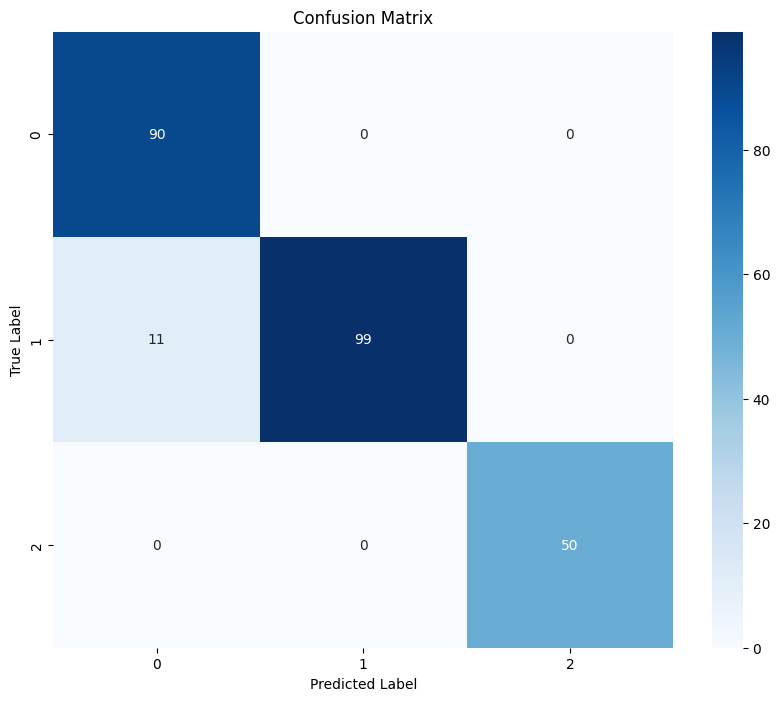

In [ ]:
def main_evaluation():
    X_test = np.load('/content/drive/MyDrive/Numpy_ADNI/AmyPET_test_images.npy', allow_pickle=True)
    Y_test = np.load('/content/drive/MyDrive/Numpy_ADNI/AmyPET_test_label.npy', allow_pickle=True)

    # Create test dataset and loader
    test_dataset = AmyloidPETDataset(X_test, Y_test, transform=val_transform)
    test_loader = DataLoader(test_dataset, batch_size=16)

    # Initialize model and load trained weights
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = PETClassifier(num_classes=3)
    model.load_state_dict(torch.load('/content/drive/MyDrive/Numpy_ADNI/best_model.pth'))
    model = model.to(device)

    # Set up criterion
    criterion = nn.CrossEntropyLoss()

    # Evaluate model
    results = evaluate_model(model, test_loader, criterion, device)

    # Print results
    print("\nTest Set Evaluation Results:")
    print(f"Average Loss: {results['loss']:.4f}")
    print(f"Accuracy: {results['accuracy']:.2f}%")
    print("\nClassification Report:")
    print(results['classification_report'])

    # Plot confusion matrix
    print("\nConfusion Matrix:")
    plot_confusion_matrix(results['confusion_matrix'])

    return results

if __name__ == '__main__':
    results = main_evaluation()

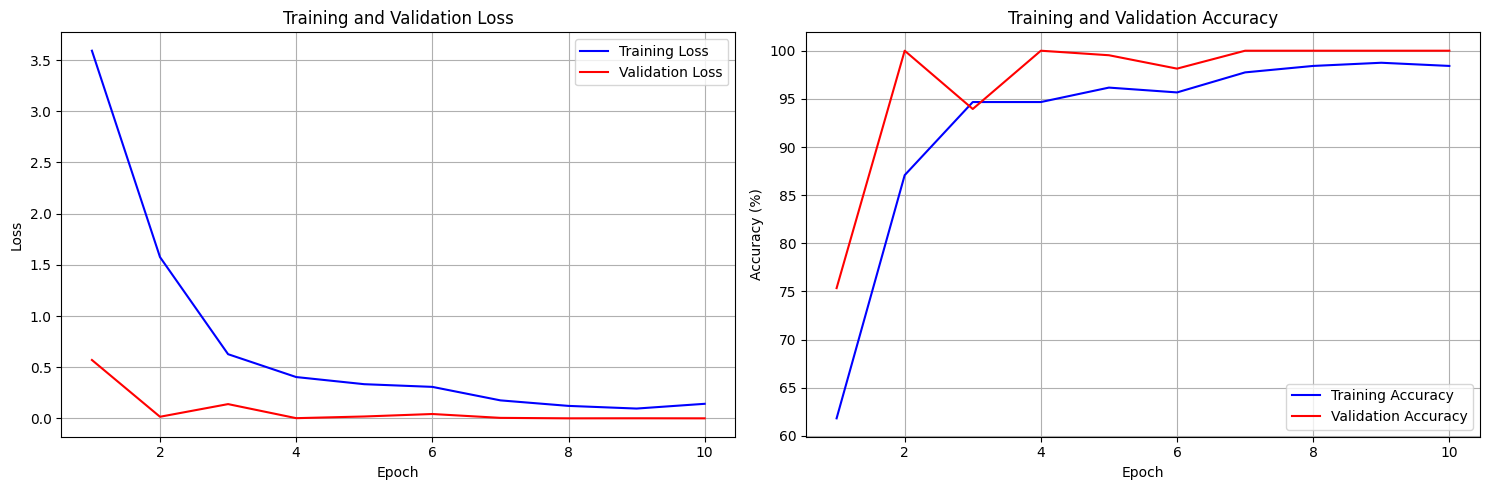


Training Analysis:
Initial training loss: 3.5919
Final training loss: 0.1422
Best training accuracy: 98.75%
Final training accuracy: 98.42%

Validation Analysis:
Initial validation loss: 0.5703
Final validation loss: 0.0002
Best validation accuracy: 100.00%
Final validation accuracy: 100.00%


In [ ]:
# Extract values from the training output
train_loss = [3.5919, 1.5754, 0.6269, 0.4036, 0.3338, 0.3076, 0.1757, 0.1218, 0.0958, 0.1422]
val_loss = [0.5703, 0.0156, 0.1393, 0.0019, 0.0183, 0.0425, 0.0048, 0.0003, 0.0009, 0.0002]
train_acc = [61.83, 87.08, 94.67, 94.67, 96.17, 95.67, 97.75, 98.42, 98.75, 98.42]
val_acc = [75.35, 100.00, 93.95, 100.00, 99.53, 98.14, 100.00, 100.00, 100.00, 100.00]

epochs = range(1, 11)

plt.figure(figsize=(15, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print some analysis
print("\nTraining Analysis:")
print(f"Initial training loss: {train_loss[0]:.4f}")
print(f"Final training loss: {train_loss[-1]:.4f}")
print(f"Best training accuracy: {max(train_acc):.2f}%")
print(f"Final training accuracy: {train_acc[-1]:.2f}%")
print("\nValidation Analysis:")
print(f"Initial validation loss: {val_loss[0]:.4f}")
print(f"Final validation loss: {val_loss[-1]:.4f}")
print(f"Best validation accuracy: {max(val_acc):.2f}%")
print(f"Final validation accuracy: {val_acc[-1]:.2f}%")


Train Set Results:
Accuracy: 99.08%


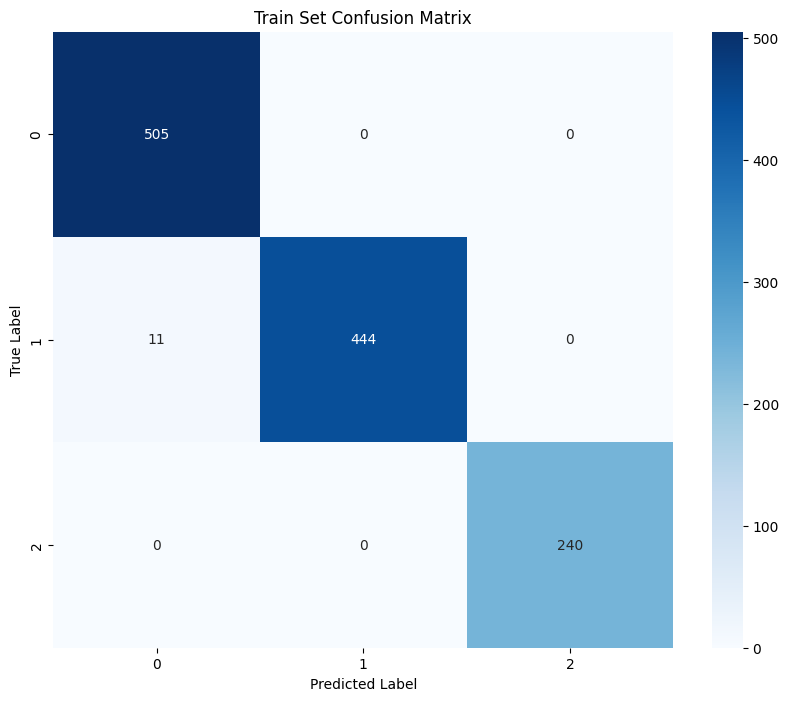


Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       505
           1       1.00      0.98      0.99       455
           2       1.00      1.00      1.00       240

    accuracy                           0.99      1200
   macro avg       0.99      0.99      0.99      1200
weighted avg       0.99      0.99      0.99      1200


Train Set Prediction Distribution:
Class 0: 516 predictions (43.00%)
Class 1: 444 predictions (37.00%)
Class 2: 240 predictions (20.00%)

Validation Set Results:
Accuracy: 100.00%


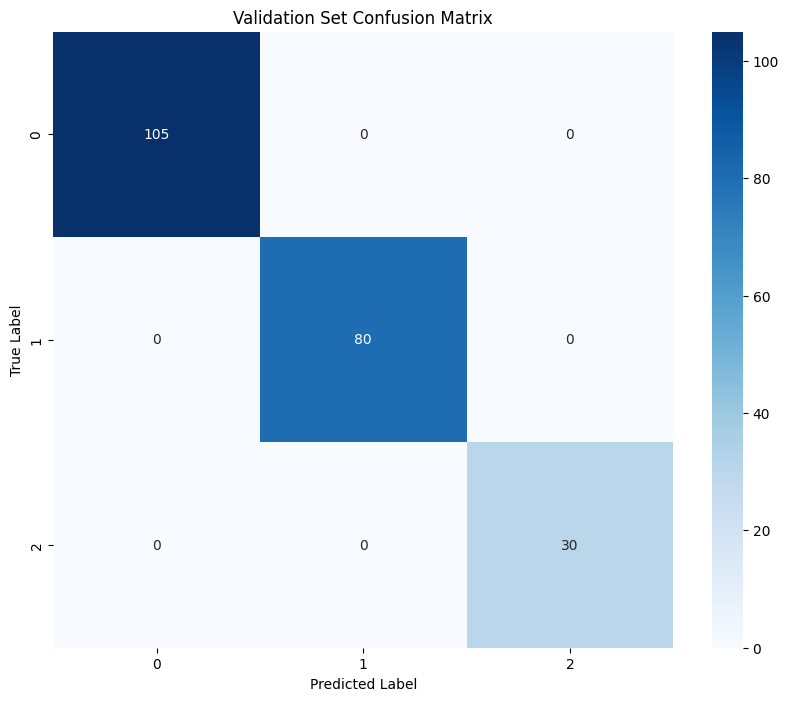


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       105
           1       1.00      1.00      1.00        80
           2       1.00      1.00      1.00        30

    accuracy                           1.00       215
   macro avg       1.00      1.00      1.00       215
weighted avg       1.00      1.00      1.00       215


Validation Set Prediction Distribution:
Class 0: 105 predictions (48.84%)
Class 1: 80 predictions (37.21%)
Class 2: 30 predictions (13.95%)

Test Set Results:
Accuracy: 95.60%


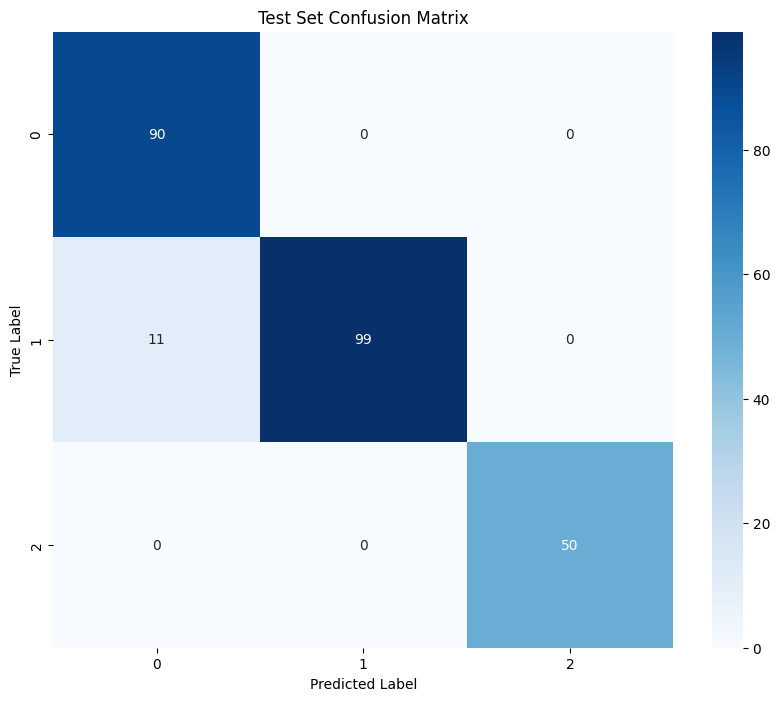


Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94        90
           1       1.00      0.90      0.95       110
           2       1.00      1.00      1.00        50

    accuracy                           0.96       250
   macro avg       0.96      0.97      0.96       250
weighted avg       0.96      0.96      0.96       250


Test Set Prediction Distribution:
Class 0: 101 predictions (40.40%)
Class 1: 99 predictions (39.60%)
Class 2: 50 predictions (20.00%)

Performance Gap Analysis:
Train-Test Gap: 3.48%
Train-Val Gap: -0.92%


In [ ]:

def evaluate_predictions(true_labels, predictions, title="Confusion Matrix"):
    # Create and plot confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(true_labels, predictions))

def check_overfitting(model, train_loader, val_loader, test_loader, device):
    model.eval()
    datasets = {'Train': train_loader, 'Validation': val_loader, 'Test': test_loader}
    results = {}

    with torch.no_grad():
        for name, loader in datasets.items():
            correct = 0
            total = 0
            all_preds = []
            all_labels = []

            for inputs, labels in loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = outputs.max(1)

                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

            accuracy = 100. * correct / total
            results[name] = {
                'accuracy': accuracy,
                'predictions': all_preds,
                'true_labels': all_labels
            }

            print(f"\n{name} Set Results:")
            print(f"Accuracy: {accuracy:.2f}%")
            evaluate_predictions(all_labels, all_preds, f"{name} Set Confusion Matrix")

            # Check prediction distribution
            print(f"\n{name} Set Prediction Distribution:")
            unique, counts = np.unique(all_preds, return_counts=True)
            for label, count in zip(unique, counts):
                print(f"Class {label}: {count} predictions ({count/len(all_preds)*100:.2f}%)")

    return results

def main():
    # Load the saved model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = PETClassifier(num_classes=3)
    model.load_state_dict(torch.load('best_model.pth'))
    model = model.to(device)

    # Load all datasets
    X_train = np.load('/content/drive/MyDrive/Numpy_ADNI/AmyPET_train_images.npy', allow_pickle=True)
    X_val = np.load('/content/drive/MyDrive/Numpy_ADNI/AmyPET_val_images.npy', allow_pickle=True)
    X_test = np.load('/content/drive/MyDrive/Numpy_ADNI/AmyPET_test_images.npy', allow_pickle=True)
    Y_train = np.load('/content/drive/MyDrive/Numpy_ADNI/AmyPET_train_label.npy', allow_pickle=True)
    Y_val = np.load('/content/drive/MyDrive/Numpy_ADNI/AmyPET_val_label.npy', allow_pickle=True)
    Y_test = np.load('/content/drive/MyDrive/Numpy_ADNI/AmyPET_test_label.npy', allow_pickle=True)

    # Create all datasets
    train_dataset = AmyloidPETDataset(X_train, Y_train, transform=val_transform)  # Use val_transform to avoid augmentation
    val_dataset = AmyloidPETDataset(X_val, Y_val, transform=val_transform)
    test_dataset = AmyloidPETDataset(X_test, Y_test, transform=val_transform)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)  # No shuffle for evaluation
    val_loader = DataLoader(val_dataset, batch_size=16)
    test_loader = DataLoader(test_dataset, batch_size=16)

    # Perform comprehensive evaluation
    results = check_overfitting(model, train_loader, val_loader, test_loader, device)

    # Additional analysis
    print("\nPerformance Gap Analysis:")
    print(f"Train-Test Gap: {results['Train']['accuracy'] - results['Test']['accuracy']:.2f}%")
    print(f"Train-Val Gap: {results['Train']['accuracy'] - results['Validation']['accuracy']:.2f}%")

if __name__ == '__main__':
    main()

In [ ]:
def create_table_border(width=80):
    return "+" + "-" * (width-2) + "+"

def create_table_row(text, width=80):
    return f"| {text:<{width-4}} |"

def create_section_header(text, width=80):
    border = create_table_border(width)
    header = create_table_row(text.upper(), width)
    return f"{border}\n{header}\n{border}"

def print_enhanced_summary(model):
    width = 80

    # Title
    print("\n" + "=" * width)
    print(f"{'PET CLASSIFIER MODEL SUMMARY':^{width}}")
    print("=" * width + "\n")

    # 1. Base Model Section
    print(create_section_header("1. Base Model Architecture", width))
    print(create_table_row("Type: Inception V3 (pretrained)", width))
    print(create_table_row("Input Size: 299 x 299 x 3", width))
    print(create_table_border(width) + "\n")

    # 2. Layer Status Section
    print(create_section_header("2. Layer Freeze Status", width))

    # Count frozen and trainable parameters
    frozen_layers = []
    trainable_layers = []
    for name, param in model.base_model.named_parameters():
        if not param.requires_grad:
            frozen_layers.append(name)
        else:
            trainable_layers.append(name)

    # Print Frozen Layers
    print(create_table_row("FROZEN LAYERS:", width))
    print(create_table_border(width))
    for layer in frozen_layers[:5]:  # Show first 5 layers
        print(create_table_row(f"  • {layer}", width))
    if len(frozen_layers) > 5:
        print(create_table_row(f"  ... and {len(frozen_layers)-5} more layers", width))

    # Print Trainable Layers
    print(create_table_border(width))
    print(create_table_row("TRAINABLE LAYERS:", width))
    print(create_table_border(width))
    for layer in trainable_layers:
        print(create_table_row(f"  • {layer}", width))
    print(create_table_border(width) + "\n")

    # 3. Custom Classifier Section
    print(create_section_header("3. Custom Classifier Architecture", width))

    classifier_layers = [
        ("Batch Normalization", f"Features: {model.base_model.fc[0].num_features}"),
        ("Dropout", f"Rate: 0.4"),
        ("Linear", f"2048 → 512"),
        ("ReLU", "Activation"),
        ("Batch Normalization", f"Features: 512"),
        ("Dropout", f"Rate: 0.4"),
        ("Linear", f"512 → 3")
    ]

    print(create_table_border(width))
    print(f"| {'Layer Type':<30} | {'Specifications':<45} |")
    print(create_table_border(width))

    for layer_type, specs in classifier_layers:
        print(f"| {layer_type:<30} | {specs:<45} |")
    print(create_table_border(width) + "\n")

    # 4. Parameter Summary Section
    print(create_section_header("4. Parameter Summary", width))

    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    frozen_params = total_params - trainable_params

    print(create_table_border(width))
    print(f"| {'Parameter Type':<30} | {'Count':<20} | {'Percentage':<23} |")
    print(create_table_border(width))
    print(f"| {'Total Parameters':<30} | {total_params:>20,d} | {100:>22.1f}% |")
    print(f"| {'Trainable Parameters':<30} | {trainable_params:>20,d} | {trainable_params/total_params*100:>22.1f}% |")
    print(f"| {'Frozen Parameters':<30} | {frozen_params:>20,d} | {frozen_params/total_params*100:>22.1f}% |")
    print(create_table_border(width) + "\n")

# Create and summarize model
model = PETClassifier(num_classes=3)
print_enhanced_summary(model)


                          PET CLASSIFIER MODEL SUMMARY                          

+------------------------------------------------------------------------------+
| 1. BASE MODEL ARCHITECTURE                                                   |
+------------------------------------------------------------------------------+
| Type: Inception V3 (pretrained)                                              |
| Input Size: 299 x 299 x 3                                                    |
+------------------------------------------------------------------------------+

+------------------------------------------------------------------------------+
| 2. LAYER FREEZE STATUS                                                       |
+------------------------------------------------------------------------------+
| FROZEN LAYERS:                                                               |
+------------------------------------------------------------------------------+
|   • Conv2d_1a_3x3.conv.